In [1]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm import tqdm
import torch
import numpy as np
from utils import img_to_tensor, tensor_to_image, gather

/Users/matt/anaconda3/envs/guided_diffusion/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reusing dataset cifar10 (/Users/matt/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 197.72it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})



/Users/matt/anaconda3/envs/guided_diffusion/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  


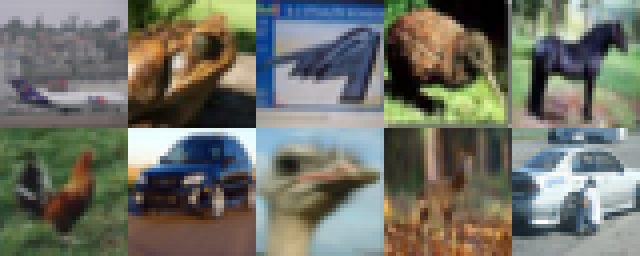

In [2]:
# ORIGINAL IMAGE LOAD CODE

#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

print(cifar10)
# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
    im = cifar10['train'][i]['img']
    image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [ ]:
import os 

playable_maps = [Image.open(f"/Users/matt/guided-diffusion/zelda_playable_map_imgs/{img_path}", mode='r', formats=None).resize((16,16)) for img_path in os.listdir("zelda_playable_map_imgs")]
playable_maps[0].resize((13,9))

## Add Noising to x_t given x_t-1

In [ ]:
# add noise to x_t given x_t-1 --> q(x_t, x_t-1)
def q_xt_xtminus1(xtm1, t, beta):
    
#     print(f"shape of beta is {beta.shape}")
#     print(f"beta is {beta}")
#     print(f"beta is {beta}")
    mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
#     print(f"mean after gather is {mean.shape}")
    var = gather(beta, t) # βt I - what is I?
    eps = torch.randn_like(xtm1) # Noise shaped like xtm1
    return mean + (var ** 0.5) * eps


def add_noise_xt_from_xtminus1(n_steps, start_img, beta):
    # Show im at different stages
    ims = []
    x = img_to_tensor(start_im).squeeze()
    for t in range(n_steps):
        # Store images every 20 steps to show progression
        if t%20 == 0:
            ims.append(tensor_to_image(x))

         # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
        t = torch.tensor(t, dtype=torch.long) # t as a tensor
        x = q_xt_xtminus1(x, t, beta) # Modify x using our function above

    return ims
        

# Refactor to load in local cifar data
start_im = cifar10['train']['img'][1]
n_steps = 100
# Beta schedule --> i.e. how often to add noise
beta = torch.linspace(0.0001, 0.04, n_steps)
ims = add_noise_xt_from_xtminus1(n_steps, start_im, beta)

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
    image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

## Add Noising  to x_t given x_0

mean shape is torch.Size([1, 3, 32, 32])
mean is tensor([[[[-0.7255, -0.3725, -0.3019,  ...,  0.2235,  0.0745,  0.2000],
          [-0.7647, -0.5059, -0.3255,  ...,  0.1294,  0.1137,  0.2078],
          [-0.6157, -0.5451, -0.2941,  ..., -0.1137, -0.1451, -0.0667],
          ...,
          [ 0.3176,  0.3412,  0.3961,  ..., -0.0118,  0.0510, -0.0274],
          [ 0.2784,  0.3647,  0.4588,  ...,  0.0431, -0.0980, -0.3098],
          [ 0.3019,  0.3804,  0.4745,  ..., -0.0353, -0.0431, -0.2078]],

         [[-0.5686, -0.2157, -0.1451,  ...,  0.4745,  0.2863,  0.3961],
          [-0.6313, -0.3568, -0.1686,  ...,  0.4274,  0.3490,  0.3961],
          [-0.4745, -0.4117, -0.1529,  ...,  0.2157,  0.0980,  0.0980],
          ...,
          [ 0.2314,  0.2627,  0.2863,  ...,  0.2392,  0.1529, -0.0431],
          [ 0.2000,  0.2706,  0.3412,  ...,  0.2784,  0.0196, -0.2863],
          [ 0.1608,  0.2314,  0.2863,  ...,  0.1137,  0.0431, -0.1529]],

         [[-0.6706, -0.3333, -0.2863,  ...,  0.3882, 

/Users/matt/anaconda3/envs/guided_diffusion/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


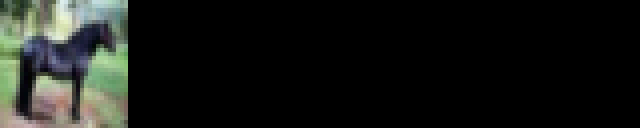

In [3]:
"""
From paper, they reparameterize 
"""

n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
    mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
    print(f"mean shape is {mean.shape}")
    print(f"mean is {mean}")
    var = 1-gather(alpha_bar, t) # (1-alpha_bar)
    print(f"var shape is {var.shape}")
    print(f"var is {var}")
    eps = torch.randn_like(x0)
    print(f"eps shape is {eps.shape}")
    print(f"eps is {eps}")
    return mean + (var ** 0.5) * eps


def add_noise_xt_from_x0(start_img, t_list):
    # Show im at different stages
    ims = []
    x = img_to_tensor(start_im).squeeze()
    for t in t_list:
        # Calculate Xt given X0 (i.e. x from the previous iteration)
        t = torch.tensor(t, dtype=torch.long) # t as a tensor
        x = q_xt_x0(x, t) # Modify x using our function above
        ims.append(tensor_to_image(x))

    return ims

# Show im at different stages
ims = []
start_im = cifar10['train'][4]['img']
x0 = img_to_tensor(start_im).squeeze()
t_list = [0, 20, 40, 60, 80]
# ims = add_noise_xt_from_x0(start_im, t_list)
ims = add_noise_xt_from_x0(start_im, [t_list[0]])

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
    image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

## Training

In [5]:
from unet import UNet

# Create the model
unet = UNet(n_channels=32)

# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
    mean = gather(alpha_bar, t) ** 0.5 * x0
    var = 1-gather(alpha_bar, t)
    eps = torch.randn_like(x0).to(x0.device)
    return mean + (var ** 0.5) * eps, eps # also returns noise

# Training params
batch_size = 128 # Lower this if hitting memory issues
lr = 2e-4 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

dataset = cifar10['train']#.select(range(10000)) # to use a 10k subset for demo

optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer

for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Run through the dataset
    ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)] # Fetch some images
    tims = [img_to_tensor(im) for im in ims] # Convert to tensors
    x0 = torch.cat(tims) # Combine into a batch
    t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long) # Random 't's 
    xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
#     print(f"xt is {xt}")
#     print(f"xt shape is {xt.shape}")
    pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
    loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets
    losses.append(loss.item()) # Store the loss for later viewing
    optim.zero_grad() # Zero the gradients
    loss.backward() # Backpropagate the loss (computes and store gradients)
    optim.step() # Update the network parameters (using those gradients)

  0%|                                                                                                                                                                                     | 0/390 [00:00<?, ?it/s]

s shape is torch.Size([128, 512, 4, 4])
x shape is torch.Size([128, 512, 4, 4])
s shape is torch.Size([128, 512, 4, 4])
x shape is torch.Size([128, 512, 4, 4])
s shape is torch.Size([128, 128, 4, 4])
x shape is torch.Size([128, 128, 4, 4])
s shape is torch.Size([128, 128, 8, 8])
x shape is torch.Size([128, 128, 8, 8])
s shape is torch.Size([128, 128, 8, 8])
x shape is torch.Size([128, 128, 8, 8])
s shape is torch.Size([128, 64, 8, 8])
x shape is torch.Size([128, 64, 8, 8])
s shape is torch.Size([128, 64, 16, 16])
x shape is torch.Size([128, 64, 16, 16])
s shape is torch.Size([128, 64, 16, 16])
x shape is torch.Size([128, 64, 16, 16])
s shape is torch.Size([128, 32, 16, 16])
x shape is torch.Size([128, 32, 16, 16])
s shape is torch.Size([128, 32, 32, 32])
x shape is torch.Size([128, 32, 32, 32])
s shape is torch.Size([128, 32, 32, 32])
x shape is torch.Size([128, 32, 32, 32])
s shape is torch.Size([128, 32, 32, 32])
x shape is torch.Size([128, 32, 32, 32])


  0%|▍                                                                                                                                                                            | 1/390 [00:06<40:42,  6.28s/it]

s shape is torch.Size([128, 512, 4, 4])
x shape is torch.Size([128, 512, 4, 4])
s shape is torch.Size([128, 512, 4, 4])
x shape is torch.Size([128, 512, 4, 4])
s shape is torch.Size([128, 128, 4, 4])
x shape is torch.Size([128, 128, 4, 4])
s shape is torch.Size([128, 128, 8, 8])
x shape is torch.Size([128, 128, 8, 8])
s shape is torch.Size([128, 128, 8, 8])
x shape is torch.Size([128, 128, 8, 8])
s shape is torch.Size([128, 64, 8, 8])
x shape is torch.Size([128, 64, 8, 8])
s shape is torch.Size([128, 64, 16, 16])
x shape is torch.Size([128, 64, 16, 16])
s shape is torch.Size([128, 64, 16, 16])
x shape is torch.Size([128, 64, 16, 16])
s shape is torch.Size([128, 32, 16, 16])
x shape is torch.Size([128, 32, 16, 16])
s shape is torch.Size([128, 32, 32, 32])
x shape is torch.Size([128, 32, 32, 32])
s shape is torch.Size([128, 32, 32, 32])
x shape is torch.Size([128, 32, 32, 32])
s shape is torch.Size([128, 32, 32, 32])
x shape is torch.Size([128, 32, 32, 32])


  0%|▍                                                                                                                                                                          | 1/390 [00:11<1:14:38, 11.51s/it]


KeyboardInterrupt: 

## Save model

In [ ]:
import pathlib
# save the model
model_name =  'diffusion_model_100.pt'
torch.save(unet.state_dict(), pathlib.Path.cwd() / model_name)

## Load model

In [ ]:
unet_loaded = UNet(n_channels=32)
unet_loaded.load_state_dict(torch.load(model_name))

## Reverse Step

In [ ]:
def p_xt(xt, noise, t):
    alpha_t = gather(alpha, t)
    alpha_bar_t = gather(alpha_bar, t)
    eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
    mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise) # Note minus sign
    var = gather(beta, t)
    eps = torch.randn(xt.shape, device=xt.device)
    return mean + (var ** 0.5) * eps 

x = torch.randn(1, 3, 32, 32) # Start with random noise
ims = []
for i in range(n_steps):
    t = torch.tensor(n_steps-i-1, dtype=torch.long)
    with torch.no_grad():
        pred_noise = unet_loaded(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if i%24 == 0:
            ims.append(tensor_to_image(x.cpu()))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
    image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

## Next Steps

### For next meeting
1. create inference script that can be called in PoD and Diffusion modes
   a. Convert to pixelated zelda map and run diffusion model on this map, then convert   back to discrete space when passing to solver to determine if level is playable
2. create training script for diffusion model
4. create training script for PoD
5. train classifier on cifar dataset to be used 


- Discrete diffusion for functional objects
### Ongoing 
* Further my intuition for what is going on granularly in the noising and reversing steps on a given (understand the math behind it as well) - https://nn.labml.ai/diffusion/ddpm/index.html
* Dig into/understand the unet model architecture - https://arxiv.org/abs/1505.04597